In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import pandas as pd
from tensorflow.keras.applications import ResNet50V2

tf.__version__

'2.3.0-dev20200522'

In [2]:
PATH = 'data'

os.listdir(PATH)

['jpeg224',
 'sample_submission.csv',
 'subset.csv',
 'test.csv',
 'train.csv',
 'train_split.csv',
 'val_split.csv']

In [3]:
#train = pd.read_csv(f'{PATH}/train.csv')
train = pd.read_csv(f'{PATH}/subset.csv')
val = pd.read_csv(f'{PATH}/val_split.csv')

train.shape, val.shape

((2220, 8), (10932, 8))

In [4]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_0533349,IP_5208504,female,45.0,lower extremity,unknown,benign,0
1,ISIC_8814612,IP_0414408,male,50.0,torso,unknown,benign,0
2,ISIC_6515241,IP_6245507,male,45.0,lower extremity,unknown,benign,0
3,ISIC_5075261,IP_2117218,male,40.0,upper extremity,unknown,benign,0
4,ISIC_2624460,IP_1969685,male,50.0,torso,unknown,benign,0


In [5]:
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

def decode(filename, label):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    return img, label

def augment(img, label):
    # augmentation
    #img = tf.image.flip_left_right(img)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return img, label

def load_ds(df):
    options = tf.data.Options()
    options.experimental_deterministic = False
    imgs, labels = df["image_name"].values, df["target"].values
    imgs = [f'{PATH}/jpeg224/train/{img}.jpg' for img in imgs]
    ds = tf.data.Dataset.from_tensor_slices((imgs, labels))
    ds = ds.with_options(options)
    ds = ds.map(decode, num_parallel_calls=AUTO)
    ds = ds.map(augment, num_parallel_calls=AUTO)
    ds = ds.cache()
    ds = ds.shuffle(2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTO)
    return ds

In [6]:
train_ds = load_ds(train)
val_ds = load_ds(val)

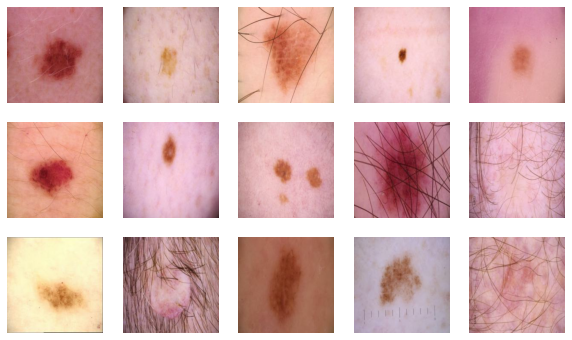

In [7]:
import matplotlib.pyplot as plt
import random

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        for imgs, labels in train_ds.take(1):
            img = imgs[0].numpy() / 255
            plt.imshow(img)
            plt.axis(False)
plt.show()

In [8]:
IMAGE_SIZE = (224, 224, 3)

encoder = ResNet50V2(
    include_top=False,
    input_shape=IMAGE_SIZE,
    weights='imagenet'
)
encoder.trainable = False

inputs = keras.Input(shape=IMAGE_SIZE)
#x = keras.layers.experimental.preprocessing.RandomFlip()(inputs)
x = keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = encoder(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
______________________________________

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.AUC(name="auc")]
)

In [10]:
filepath = './checkpoints/checkpoint'
cb = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    monitor="val_auc",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="max"
)

In [11]:
model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    validation_steps=10,
    callbacks=[cb]
)

Epoch 1/10
35/35 [==============================] - ETA: 0s - loss: 0.1797 - auc: 0.5205
Epoch 00001: val_auc improved from -inf to 0.46483, saving model to ./checkpoints\checkpoint
35/35 [==============================] - 12s 349ms/step - loss: 0.1797 - auc: 0.5205 - val_loss: 0.1792 - val_auc: 0.4648
Epoch 2/10
35/35 [==============================] - ETA: 0s - loss: 0.1070 - auc: 0.4709
Epoch 00002: val_auc improved from 0.46483 to 0.61452, saving model to ./checkpoints\checkpoint
35/35 [==============================] - 11s 303ms/step - loss: 0.1070 - auc: 0.4709 - val_loss: 0.0824 - val_auc: 0.6145
Epoch 3/10
35/35 [==============================] - ETA: 0s - loss: 0.0906 - auc: 0.6277
Epoch 00003: val_auc improved from 0.61452 to 0.68485, saving model to ./checkpoints\checkpoint
35/35 [==============================] - 11s 302ms/step - loss: 0.0906 - auc: 0.6277 - val_loss: 0.0897 - val_auc: 0.6848
Epoch 4/10
35/35 [==============================] - ETA: 0s - loss: 0.0818 - auc: 

In [12]:
model.load_weights(filepath)
model.save("model.h5")

In [13]:
model.evaluate(val_ds)

171/171 [==============================] - 38s 221ms/step - loss: 0.0785 - auc: 0.7842


[0.07854363322257996, 0.7841859459877014]

In [14]:
test = pd.read_csv(f'{PATH}/test.csv')

test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [15]:
def decode_test(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    return img

def load_test_ds(df):
    imgs = df["image_name"].values
    imgs = [f'{PATH}/jpeg224/test/{img}.jpg' for img in imgs]
    ds = tf.data.Dataset.from_tensor_slices(imgs)
    ds = ds.map(decode_test)
    ds = ds.batch(BATCH_SIZE)
    return ds

In [16]:
test_ds = load_test_ds(test)

In [17]:
preds = model.predict(test_ds)

In [18]:
preds

array([[0.00764148],
       [0.01475366],
       [0.00993064],
       ...,
       [0.0680723 ],
       [0.0022741 ],
       [0.06529365]], dtype=float32)

In [19]:
submission = pd.DataFrame({'image_name': test['image_name'].values, 'target': preds.ravel()})

submission

,image_name,target
0,ISIC_0052060,0.007641
1,ISIC_0052349,0.014754
2,ISIC_0058510,0.009931
3,ISIC_0073313,0.000550
4,ISIC_0073502,0.143204
...,...,...
10977,ISIC_9992485,0.012753
10978,ISIC_9996992,0.047244
10979,ISIC_9997917,0.068072
10980,ISIC_9998234,0.002274


In [20]:
submission.to_csv('submission.csv', index=False)